# Load images

Loads all images in the training dataset, summarizes their shape to ensure the images were loaded correctly, then saves the arrays to a new file called maps_256.npz in compressed NumPy array format.

In [1]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,512)):
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # split into satellite and map
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.7.0


In [3]:
# dataset path
path = 'maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)


Loaded:  (39, 256, 256, 3) (39, 256, 256, 3)
Saved dataset:  maps_256.npz


Plot some images pairs to confirm the data has been handled correctly.
Loads the prepared dataset and summarizes the shape of each array, confirming our expectations of a little over one thousand 256×256 image pairs.

Loaded:  (39, 256, 256, 3) (39, 256, 256, 3)


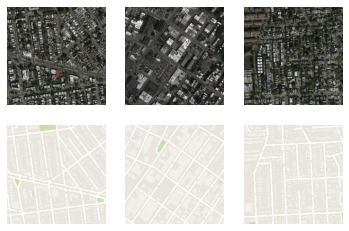

In [4]:
from numpy import load
from matplotlib import pyplot
# load the dataset with numpy storage array data
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot the source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(src_images[i].astype('uint8'))
# plot the target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()


# Develop and Train a Pix2Pix Model - satellite photos to Google maps images.

Implements the 70×70 PatchGAN discriminator model. 
The model takes two input images that are concatenated together and predicts a patch output of predictions. The model is optimized using binary cross entropy, and a weighting is used so that updates to the model have half (0.5) the usual effect.

## Discriminator model

In [5]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # link images in a series channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define the model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

Implements the U-Net encoder-decoder generator model. It uses the define_encoder_block() helper function to create blocks of layers for the encoder and the decoder_block() function to create blocks of layers for the decoder. The Tanh activation function is used in the output layer, meaning that pixel values in the generated image will be in the range [-1,1].

The discriminator model is trained directly on real and generated images, whereas the generator model is not.

## Generator model

In [6]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    #tf.keras.initializers.RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # activation with LeakyReLU
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

Takes the already-defined generator and discriminator models as arguments and uses the Keras functional API to connect them together into a composite model. Both loss functions are specified for the two outputs of the model and the weights used for each are specified in the loss_weights argument to the compile() function.

In [7]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [8]:
# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

The generate_real_samples() function below will prepare a batch of random pairs of images from the training dataset, and the corresponding discriminator label of class=1 to indicate they are real.

In [9]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

The generate_fake_samples() function below uses the generator model and a batch of real source images to generate an equivalent batch of target images for the discriminator.

These are returned with the label class-0 to indicate to the discriminator that they are fake.

In [10]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

The summarize_performance() function implements this, taking the generator model at a point during training and using it to generate a number, in this case three, of translations of randomly selected images in the dataset. The source, generated image, and expected target are then plotted as three rows of images and the plot saved to file.

In [11]:
# generate samples, save as a plot, and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# Train the generator and discriminator models.

In [12]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
            # generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            # summarize performance
            print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
            # summarize model performance
            if (i+1) % (bat_per_epo * 10) == 0:
                      summarize_performance(i, g_model, dataset)
# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (39, 256, 256, 3) (39, 256, 256, 3)


C:\Users\Kip\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, d1[0.456] d2[0.600] g[74.381]
>2, d1[0.377] d2[0.536] g[83.603]
>3, d1[0.361] d2[0.481] g[81.234]
>4, d1[0.415] d2[0.435] g[69.984]
>5, d1[0.309] d2[0.623] g[58.347]
>6, d1[0.413] d2[0.603] g[68.584]
>7, d1[0.375] d2[0.768] g[62.972]
>8, d1[0.301] d2[0.503] g[68.188]
>9, d1[0.281] d2[0.396] g[62.082]
>10, d1[0.231] d2[0.275] g[59.413]
>11, d1[0.126] d2[0.291] g[58.203]
>12, d1[0.207] d2[0.231] g[57.740]
>13, d1[0.233] d2[0.228] g[51.679]
>14, d1[0.136] d2[0.178] g[51.709]
>15, d1[0.084] d2[0.110] g[49.299]
>16, d1[0.064] d2[0.139] g[46.178]
>17, d1[0.050] d2[0.099] g[42.904]
>18, d1[0.173] d2[0.233] g[39.066]
>19, d1[0.139] d2[0.097] g[38.458]
>20, d1[0.132] d2[0.184] g[36.922]
>21, d1[0.172] d2[0.116] g[31.365]
>22, d1[0.033] d2[0.057] g[31.774]
>23, d1[0.249] d2[0.774] g[27.403]
>24, d1[0.228] d2[0.023] g[29.981]
>25, d1[0.431] d2[0.342] g[24.731]
>26, d1[0.068] d2[0.684] g[28.896]
>27, d1[0.208] d2[0.029] g[23.604]
>28, d1[1.020] d2[0.444] g[19.030]
>29, d1[0.060] d2[0.245] g[18

>234, d1[0.121] d2[0.051] g[13.245]
>235, d1[0.684] d2[0.180] g[8.946]
>236, d1[0.037] d2[0.161] g[13.454]
>237, d1[0.110] d2[0.087] g[19.615]
>238, d1[0.320] d2[0.277] g[8.126]
>239, d1[0.035] d2[0.063] g[18.880]
>240, d1[0.053] d2[0.064] g[19.881]
>241, d1[0.023] d2[0.121] g[26.584]
>242, d1[0.054] d2[0.263] g[15.531]
>243, d1[0.858] d2[0.273] g[14.086]
>244, d1[0.512] d2[0.432] g[11.985]
>245, d1[0.653] d2[0.406] g[17.101]
>246, d1[0.171] d2[0.306] g[8.639]
>247, d1[0.209] d2[0.142] g[20.437]
>248, d1[0.349] d2[0.401] g[9.872]
>249, d1[0.131] d2[0.059] g[15.188]
>250, d1[0.111] d2[0.129] g[11.744]
>251, d1[0.212] d2[0.166] g[9.831]
>252, d1[0.012] d2[0.151] g[14.943]
>253, d1[0.198] d2[0.193] g[12.083]
>254, d1[0.050] d2[0.146] g[11.581]
>255, d1[0.544] d2[0.187] g[8.662]
>256, d1[0.042] d2[0.049] g[14.933]
>257, d1[0.493] d2[0.156] g[10.556]
>258, d1[0.099] d2[0.506] g[9.618]
>259, d1[0.172] d2[0.194] g[9.398]
>260, d1[0.062] d2[0.035] g[20.641]
>261, d1[0.235] d2[0.232] g[8.990]
>

>458, d1[0.536] d2[0.292] g[10.073]
>459, d1[0.068] d2[0.322] g[9.961]
>460, d1[1.070] d2[0.229] g[8.607]
>461, d1[0.003] d2[0.082] g[13.807]
>462, d1[0.417] d2[0.190] g[8.829]
>463, d1[0.089] d2[0.267] g[9.001]
>464, d1[0.233] d2[0.165] g[8.868]
>465, d1[0.004] d2[0.062] g[20.733]
>466, d1[0.176] d2[0.197] g[9.130]
>467, d1[0.088] d2[0.210] g[9.238]
>468, d1[0.306] d2[0.109] g[9.656]
>469, d1[0.026] d2[0.473] g[13.704]
>470, d1[0.014] d2[0.023] g[21.352]
>471, d1[0.756] d2[0.170] g[9.789]
>472, d1[0.018] d2[0.084] g[13.685]
>473, d1[1.182] d2[0.319] g[17.526]
>474, d1[0.185] d2[0.353] g[9.249]
>475, d1[0.091] d2[0.136] g[9.011]
>476, d1[0.146] d2[0.153] g[9.057]
>477, d1[0.151] d2[0.078] g[20.069]
>478, d1[0.292] d2[0.238] g[11.397]
>479, d1[0.007] d2[0.197] g[10.989]
>480, d1[0.005] d2[0.115] g[20.259]
>481, d1[0.008] d2[0.054] g[13.992]
>482, d1[0.945] d2[0.211] g[15.271]
>483, d1[0.773] d2[0.538] g[9.835]
>484, d1[0.117] d2[0.481] g[12.428]
>485, d1[0.513] d2[0.210] g[10.933]
>486,

>689, d1[0.409] d2[0.335] g[9.559]
>690, d1[0.298] d2[0.372] g[8.418]
>691, d1[0.063] d2[0.094] g[12.531]
>692, d1[0.140] d2[0.139] g[13.332]
>693, d1[0.014] d2[0.079] g[15.861]
>694, d1[0.013] d2[0.061] g[18.085]
>695, d1[0.008] d2[0.038] g[24.985]
>696, d1[0.659] d2[0.192] g[8.631]
>697, d1[0.044] d2[0.125] g[13.953]
>698, d1[0.389] d2[0.354] g[7.498]
>699, d1[0.154] d2[0.225] g[8.133]
>700, d1[0.150] d2[0.216] g[7.729]
>701, d1[0.020] d2[0.038] g[15.795]
>702, d1[0.454] d2[0.056] g[16.696]
>703, d1[1.012] d2[0.328] g[10.228]
>704, d1[0.131] d2[0.353] g[8.943]
>705, d1[0.140] d2[0.398] g[9.147]
>706, d1[0.132] d2[0.253] g[7.779]
>707, d1[0.589] d2[0.143] g[8.929]
>708, d1[0.092] d2[0.275] g[8.362]
>709, d1[0.010] d2[0.099] g[9.566]
>710, d1[0.184] d2[0.227] g[8.274]
>711, d1[0.241] d2[0.261] g[7.764]
>712, d1[0.003] d2[0.039] g[26.765]
>713, d1[0.536] d2[0.237] g[12.271]
>714, d1[0.168] d2[0.615] g[10.295]
>715, d1[0.004] d2[0.021] g[14.141]
>716, d1[0.929] d2[0.285] g[11.381]
>717, 

>915, d1[0.002] d2[0.041] g[15.043]
>916, d1[0.452] d2[0.212] g[7.794]
>917, d1[0.001] d2[0.064] g[12.014]
>918, d1[0.001] d2[0.106] g[14.100]
>919, d1[0.221] d2[0.301] g[8.785]
>920, d1[0.087] d2[0.159] g[8.200]
>921, d1[0.003] d2[0.023] g[12.050]
>922, d1[0.008] d2[0.020] g[18.413]
>923, d1[0.758] d2[0.304] g[7.774]
>924, d1[0.005] d2[0.057] g[12.923]
>925, d1[0.004] d2[0.071] g[11.136]
>926, d1[0.033] d2[0.078] g[14.583]
>927, d1[0.727] d2[0.178] g[7.879]
>928, d1[0.017] d2[0.258] g[13.214]
>929, d1[0.263] d2[0.174] g[8.254]
>930, d1[0.159] d2[0.162] g[8.385]
>931, d1[0.240] d2[0.308] g[8.133]
>932, d1[0.728] d2[0.297] g[10.956]
>933, d1[0.054] d2[0.507] g[8.228]
>934, d1[0.037] d2[0.095] g[11.229]
>935, d1[0.513] d2[0.110] g[6.528]
>936, d1[0.622] d2[0.323] g[6.693]
>937, d1[0.075] d2[0.423] g[7.748]
>938, d1[0.162] d2[0.281] g[7.042]
>939, d1[0.009] d2[0.113] g[10.919]
>940, d1[0.019] d2[0.069] g[13.547]
>941, d1[0.209] d2[0.079] g[13.626]
>942, d1[0.563] d2[0.696] g[10.122]
>943,

>1143, d1[0.229] d2[0.311] g[7.961]
>1144, d1[0.136] d2[0.271] g[7.317]
>1145, d1[0.201] d2[0.265] g[7.287]
>1146, d1[0.119] d2[0.064] g[13.082]
>1147, d1[0.194] d2[0.364] g[6.858]
>1148, d1[0.234] d2[0.290] g[9.035]
>1149, d1[0.203] d2[0.151] g[10.655]
>1150, d1[0.842] d2[0.239] g[7.135]
>1151, d1[0.245] d2[0.440] g[7.399]
>1152, d1[0.274] d2[0.236] g[8.670]
>1153, d1[0.108] d2[0.249] g[7.771]
>1154, d1[0.401] d2[0.216] g[7.193]
>1155, d1[0.016] d2[0.297] g[12.435]
>1156, d1[0.407] d2[0.130] g[7.776]
>1157, d1[0.180] d2[0.290] g[6.601]
>1158, d1[0.202] d2[0.083] g[11.634]
>1159, d1[0.239] d2[0.525] g[7.593]
>1160, d1[0.064] d2[0.125] g[14.420]
>1161, d1[0.500] d2[0.171] g[7.404]
>1162, d1[0.136] d2[0.390] g[7.122]
>1163, d1[0.192] d2[0.249] g[7.192]
>1164, d1[0.154] d2[0.108] g[9.439]
>1165, d1[0.166] d2[0.246] g[6.599]
>1166, d1[0.151] d2[0.895] g[10.976]
>1167, d1[0.944] d2[0.063] g[8.918]
>1168, d1[0.814] d2[0.442] g[10.846]
>1169, d1[0.104] d2[0.484] g[6.280]
>1170, d1[0.618] d2[0

>1364, d1[0.258] d2[0.187] g[6.614]
>1365, d1[0.201] d2[0.367] g[8.550]
>1366, d1[0.499] d2[0.304] g[5.274]
>1367, d1[0.033] d2[0.125] g[18.908]
>1368, d1[0.464] d2[0.183] g[6.961]
>1369, d1[0.202] d2[0.415] g[9.166]
>1370, d1[0.103] d2[0.258] g[9.131]
>1371, d1[0.522] d2[0.230] g[7.995]
>1372, d1[0.104] d2[0.426] g[7.229]
>1373, d1[0.168] d2[0.194] g[7.121]
>1374, d1[0.612] d2[0.298] g[8.998]
>1375, d1[0.226] d2[0.328] g[6.908]
>1376, d1[0.569] d2[0.466] g[8.023]
>1377, d1[0.431] d2[0.209] g[6.739]
>1378, d1[0.116] d2[0.258] g[9.697]
>1379, d1[0.203] d2[0.330] g[6.678]
>1380, d1[0.213] d2[0.308] g[6.877]
>1381, d1[0.153] d2[0.317] g[6.545]
>1382, d1[0.503] d2[0.306] g[7.326]
>1383, d1[0.187] d2[0.146] g[13.476]
>1384, d1[0.051] d2[0.227] g[10.191]
>1385, d1[0.260] d2[0.379] g[8.954]
>1386, d1[0.299] d2[0.227] g[8.244]
>1387, d1[0.241] d2[0.528] g[6.831]
>1388, d1[0.438] d2[0.197] g[7.153]
>1389, d1[0.259] d2[0.209] g[8.608]
>1390, d1[0.137] d2[0.454] g[6.780]
>1391, d1[0.501] d2[0.245

>1585, d1[0.384] d2[0.224] g[6.771]
>1586, d1[0.314] d2[0.412] g[8.466]
>1587, d1[0.088] d2[0.211] g[6.211]
>1588, d1[0.139] d2[0.129] g[7.976]
>1589, d1[0.156] d2[0.200] g[6.793]
>1590, d1[0.199] d2[0.270] g[5.790]
>1591, d1[0.096] d2[0.160] g[6.592]
>1592, d1[0.165] d2[0.204] g[6.819]
>1593, d1[0.115] d2[0.138] g[7.299]
>1594, d1[0.183] d2[0.292] g[6.249]
>1595, d1[0.246] d2[0.169] g[8.058]
>1596, d1[0.367] d2[0.348] g[6.593]
>1597, d1[0.127] d2[0.165] g[6.599]
>1598, d1[0.061] d2[0.230] g[9.412]
>1599, d1[0.227] d2[0.182] g[9.261]
>1600, d1[0.140] d2[0.165] g[6.759]
>1601, d1[0.216] d2[0.269] g[6.396]
>1602, d1[0.085] d2[0.246] g[6.770]
>1603, d1[0.219] d2[0.176] g[6.711]
>1604, d1[0.101] d2[0.177] g[6.477]
>1605, d1[0.140] d2[0.384] g[8.719]
>1606, d1[0.206] d2[0.108] g[6.788]
>1607, d1[0.306] d2[0.294] g[9.719]
>1608, d1[0.531] d2[0.261] g[7.252]
>1609, d1[0.382] d2[0.402] g[5.856]
>1610, d1[0.061] d2[0.234] g[6.240]
>1611, d1[0.535] d2[0.351] g[7.220]
>1612, d1[0.541] d2[0.646] g

>1813, d1[0.105] d2[0.188] g[6.992]
>1814, d1[0.057] d2[0.148] g[10.344]
>1815, d1[0.079] d2[0.177] g[9.986]
>1816, d1[0.378] d2[0.176] g[6.276]
>1817, d1[0.072] d2[0.264] g[9.568]
>1818, d1[0.200] d2[0.111] g[6.739]
>1819, d1[0.552] d2[0.135] g[7.802]
>1820, d1[0.050] d2[0.639] g[10.183]
>1821, d1[0.111] d2[0.085] g[7.216]
>1822, d1[0.307] d2[0.177] g[6.303]
>1823, d1[0.258] d2[0.264] g[5.244]
>1824, d1[0.076] d2[0.252] g[6.558]
>1825, d1[0.509] d2[0.187] g[7.603]
>1826, d1[0.041] d2[0.238] g[6.904]
>1827, d1[0.045] d2[0.156] g[7.413]
>1828, d1[0.104] d2[0.066] g[8.470]
>1829, d1[0.045] d2[0.338] g[7.714]
>1830, d1[0.287] d2[0.156] g[6.033]
>1831, d1[0.163] d2[0.140] g[7.019]
>1832, d1[0.215] d2[0.582] g[5.737]
>1833, d1[0.139] d2[0.129] g[9.344]
>1834, d1[0.079] d2[0.279] g[7.567]
>1835, d1[0.294] d2[0.084] g[7.530]
>1836, d1[1.141] d2[0.166] g[5.941]
>1837, d1[0.453] d2[0.429] g[5.554]
>1838, d1[0.089] d2[0.178] g[6.360]
>1839, d1[0.361] d2[0.314] g[6.005]
>1840, d1[0.293] d2[0.277]

>2035, d1[0.034] d2[0.144] g[7.795]
>2036, d1[0.154] d2[0.123] g[6.828]
>2037, d1[0.268] d2[0.261] g[6.511]
>2038, d1[0.042] d2[0.172] g[7.802]
>2039, d1[0.502] d2[0.161] g[6.315]
>2040, d1[0.259] d2[0.210] g[6.606]
>2041, d1[0.014] d2[0.411] g[8.027]
>2042, d1[0.062] d2[0.202] g[6.814]
>2043, d1[0.716] d2[0.089] g[6.701]
>2044, d1[0.378] d2[0.286] g[6.284]
>2045, d1[0.049] d2[0.229] g[7.228]
>2046, d1[0.119] d2[0.239] g[7.075]
>2047, d1[0.194] d2[0.274] g[6.818]
>2048, d1[0.439] d2[0.131] g[6.326]
>2049, d1[0.182] d2[0.412] g[5.488]
>2050, d1[0.126] d2[0.266] g[6.418]
>2051, d1[0.237] d2[0.215] g[6.152]
>2052, d1[0.099] d2[0.146] g[6.813]
>2053, d1[0.149] d2[0.205] g[6.672]
>2054, d1[0.166] d2[0.354] g[6.514]
>2055, d1[0.510] d2[0.227] g[6.069]
>2056, d1[0.159] d2[0.238] g[6.182]
>2057, d1[0.146] d2[0.271] g[7.620]
>2058, d1[0.168] d2[0.178] g[7.569]
>2059, d1[0.111] d2[0.115] g[6.878]
>2060, d1[0.167] d2[0.211] g[9.766]
>2061, d1[0.456] d2[0.391] g[6.281]
>2062, d1[0.332] d2[0.255] g

>2263, d1[0.052] d2[0.604] g[5.946]
>2264, d1[0.108] d2[0.191] g[6.913]
>2265, d1[0.336] d2[0.583] g[7.084]
>2266, d1[0.085] d2[0.159] g[11.525]
>2267, d1[0.515] d2[0.173] g[6.439]
>2268, d1[0.056] d2[0.320] g[6.418]
>2269, d1[0.103] d2[0.141] g[6.896]
>2270, d1[0.294] d2[0.143] g[6.344]
>2271, d1[0.067] d2[0.222] g[9.565]
>2272, d1[0.186] d2[0.159] g[6.830]
>2273, d1[0.341] d2[0.189] g[6.179]
>2274, d1[0.175] d2[0.157] g[7.399]
>2275, d1[0.077] d2[0.270] g[7.477]
>2276, d1[0.047] d2[0.126] g[8.053]
>2277, d1[0.327] d2[0.152] g[6.961]
>2278, d1[0.095] d2[0.201] g[6.953]
>2279, d1[0.128] d2[0.106] g[6.453]
>2280, d1[0.550] d2[0.257] g[6.659]
>2281, d1[0.030] d2[0.336] g[8.194]
>2282, d1[0.072] d2[0.191] g[7.101]
>2283, d1[0.115] d2[0.193] g[6.650]
>2284, d1[0.366] d2[0.156] g[6.451]
>2285, d1[0.235] d2[0.248] g[6.986]
>2286, d1[0.633] d2[0.199] g[6.341]
>2287, d1[0.082] d2[0.402] g[7.382]
>2288, d1[0.181] d2[0.145] g[6.290]
>2289, d1[0.182] d2[0.195] g[6.777]
>2290, d1[0.121] d2[0.166] 

>2485, d1[0.201] d2[0.179] g[6.476]
>2486, d1[0.389] d2[0.142] g[6.816]
>2487, d1[0.019] d2[0.303] g[7.427]
>2488, d1[0.232] d2[0.081] g[5.946]
>2489, d1[0.062] d2[0.138] g[6.697]
>2490, d1[0.054] d2[0.153] g[7.492]
>2491, d1[0.176] d2[0.112] g[8.309]
>2492, d1[0.060] d2[0.403] g[8.181]
>2493, d1[0.281] d2[0.258] g[7.105]
>2494, d1[0.127] d2[0.394] g[6.666]
>2495, d1[0.146] d2[0.282] g[6.427]
>2496, d1[0.363] d2[0.118] g[8.515]
>2497, d1[0.103] d2[0.274] g[6.381]
>2498, d1[0.259] d2[0.352] g[6.408]
>2499, d1[0.304] d2[0.248] g[6.070]
>2500, d1[0.244] d2[0.821] g[6.914]
>2501, d1[0.250] d2[0.173] g[6.726]
>2502, d1[0.144] d2[0.389] g[7.109]
>2503, d1[0.274] d2[0.148] g[6.349]
>2504, d1[0.407] d2[0.147] g[6.229]
>2505, d1[0.066] d2[0.351] g[6.571]
>2506, d1[0.263] d2[0.140] g[5.930]
>2507, d1[0.186] d2[0.247] g[6.626]
>2508, d1[0.108] d2[0.171] g[6.572]
>2509, d1[0.117] d2[0.192] g[6.453]
>2510, d1[0.184] d2[0.151] g[7.431]
>2511, d1[0.747] d2[0.406] g[5.204]
>2512, d1[1.336] d2[0.558] g

>2713, d1[0.263] d2[0.160] g[5.843]
>2714, d1[0.098] d2[0.145] g[6.666]
>2715, d1[0.023] d2[0.175] g[8.138]
>2716, d1[0.104] d2[0.078] g[6.340]
>2717, d1[0.371] d2[0.241] g[5.941]
>2718, d1[0.035] d2[0.148] g[10.375]
>2719, d1[0.074] d2[0.111] g[7.810]
>2720, d1[0.166] d2[0.137] g[6.460]
>2721, d1[0.181] d2[0.144] g[6.215]
>2722, d1[0.041] d2[0.072] g[7.810]
>2723, d1[0.037] d2[0.269] g[6.467]
>2724, d1[0.088] d2[0.064] g[7.047]
>2725, d1[0.204] d2[0.165] g[6.054]
>2726, d1[0.093] d2[0.075] g[6.688]
>2727, d1[0.055] d2[0.193] g[7.068]
>2728, d1[0.084] d2[0.091] g[6.957]
>2729, d1[0.180] d2[0.101] g[6.978]
>2730, d1[0.192] d2[0.094] g[6.233]
>Saved: plot_002730.png and model_002730.h5
>2731, d1[0.047] d2[0.482] g[7.390]
>2732, d1[0.154] d2[0.174] g[5.780]
>2733, d1[0.337] d2[0.407] g[5.322]
>2734, d1[0.236] d2[0.159] g[6.614]
>2735, d1[0.056] d2[0.212] g[6.999]
>2736, d1[0.269] d2[0.158] g[6.913]
>2737, d1[0.057] d2[0.219] g[6.560]
>2738, d1[0.095] d2[0.135] g[5.727]
>2739, d1[0.424] d2

>2935, d1[0.204] d2[0.265] g[5.886]
>2936, d1[0.241] d2[0.119] g[6.010]
>2937, d1[0.054] d2[0.245] g[7.870]
>2938, d1[0.075] d2[0.207] g[7.911]
>2939, d1[0.268] d2[0.204] g[5.798]
>2940, d1[0.168] d2[0.252] g[6.007]
>2941, d1[0.235] d2[0.165] g[5.296]
>2942, d1[0.174] d2[0.204] g[6.445]
>2943, d1[0.248] d2[0.263] g[5.162]
>2944, d1[0.290] d2[0.252] g[5.807]
>2945, d1[0.232] d2[0.200] g[5.931]
>2946, d1[0.079] d2[0.156] g[7.698]
>2947, d1[0.140] d2[0.191] g[6.020]
>2948, d1[0.092] d2[0.176] g[6.017]
>2949, d1[0.215] d2[0.184] g[6.699]
>2950, d1[0.146] d2[0.223] g[6.462]
>2951, d1[0.239] d2[0.177] g[6.535]
>2952, d1[0.205] d2[0.194] g[6.369]
>2953, d1[0.071] d2[0.223] g[5.902]
>2954, d1[0.201] d2[0.146] g[5.933]
>2955, d1[0.189] d2[0.237] g[5.831]
>2956, d1[0.079] d2[0.230] g[6.077]
>2957, d1[0.198] d2[0.096] g[7.506]
>2958, d1[0.167] d2[0.138] g[6.404]
>2959, d1[0.107] d2[0.165] g[6.045]
>2960, d1[0.197] d2[0.231] g[5.083]
>2961, d1[0.135] d2[0.199] g[6.240]
>2962, d1[0.074] d2[0.158] g

>3157, d1[0.159] d2[0.174] g[6.830]
>3158, d1[0.080] d2[0.265] g[6.395]
>3159, d1[0.121] d2[0.240] g[5.316]
>3160, d1[0.241] d2[0.147] g[5.776]
>3161, d1[0.230] d2[0.197] g[5.642]
>3162, d1[0.278] d2[0.147] g[6.125]
>3163, d1[0.058] d2[0.403] g[6.640]
>3164, d1[0.177] d2[0.095] g[6.704]
>3165, d1[0.134] d2[0.150] g[7.851]
>3166, d1[0.172] d2[0.191] g[6.232]
>3167, d1[0.163] d2[0.189] g[6.165]
>3168, d1[0.131] d2[0.131] g[6.196]
>3169, d1[0.318] d2[0.210] g[7.566]
>3170, d1[0.043] d2[0.213] g[5.818]
>3171, d1[0.112] d2[0.104] g[6.181]
>3172, d1[0.138] d2[0.162] g[6.025]
>3173, d1[0.238] d2[0.156] g[6.600]
>3174, d1[0.074] d2[0.156] g[5.958]
>3175, d1[0.099] d2[0.115] g[6.295]
>3176, d1[0.150] d2[0.080] g[5.510]
>3177, d1[0.049] d2[0.093] g[7.661]
>3178, d1[0.049] d2[0.229] g[5.910]
>3179, d1[0.188] d2[0.142] g[6.086]
>3180, d1[0.150] d2[0.204] g[5.944]
>3181, d1[0.252] d2[0.276] g[5.185]
>3182, d1[0.096] d2[0.098] g[6.157]
>3183, d1[0.099] d2[0.094] g[6.094]
>3184, d1[0.165] d2[0.071] g

>3385, d1[0.215] d2[0.143] g[5.926]
>3386, d1[0.061] d2[0.091] g[5.471]
>3387, d1[0.025] d2[0.211] g[5.669]
>3388, d1[0.088] d2[0.102] g[5.727]
>3389, d1[0.136] d2[0.169] g[6.099]
>3390, d1[0.057] d2[0.069] g[6.890]
>3391, d1[0.072] d2[0.143] g[5.796]
>3392, d1[0.203] d2[0.055] g[6.483]
>3393, d1[0.028] d2[0.082] g[5.720]
>3394, d1[0.072] d2[0.237] g[7.077]
>3395, d1[0.107] d2[0.236] g[6.103]
>3396, d1[0.163] d2[0.130] g[6.325]
>3397, d1[0.103] d2[0.152] g[6.241]
>3398, d1[0.021] d2[0.060] g[6.981]
>3399, d1[0.810] d2[0.132] g[4.568]
>3400, d1[0.174] d2[0.181] g[5.350]
>3401, d1[0.025] d2[0.361] g[7.132]
>3402, d1[0.258] d2[0.301] g[6.071]
>3403, d1[0.183] d2[0.138] g[6.362]
>3404, d1[0.362] d2[0.452] g[5.150]
>3405, d1[0.587] d2[0.217] g[4.730]
>3406, d1[0.099] d2[0.324] g[6.069]
>3407, d1[0.434] d2[0.484] g[5.303]
>3408, d1[0.062] d2[0.144] g[5.319]
>3409, d1[0.340] d2[0.152] g[4.988]
>3410, d1[0.131] d2[0.326] g[5.100]
>3411, d1[0.193] d2[0.161] g[5.745]
>3412, d1[0.139] d2[0.160] g

>3607, d1[0.043] d2[0.069] g[6.315]
>3608, d1[0.025] d2[0.229] g[6.296]
>3609, d1[0.032] d2[0.124] g[6.927]
>3610, d1[0.280] d2[0.068] g[7.281]
>3611, d1[0.201] d2[0.031] g[7.051]
>3612, d1[0.016] d2[0.248] g[6.621]
>3613, d1[0.039] d2[0.113] g[6.851]
>3614, d1[0.123] d2[0.107] g[7.063]
>3615, d1[0.027] d2[0.052] g[7.990]
>3616, d1[0.164] d2[0.169] g[6.641]
>3617, d1[1.004] d2[0.497] g[5.345]
>3618, d1[0.104] d2[0.600] g[7.231]
>3619, d1[0.423] d2[0.379] g[6.010]
>3620, d1[0.621] d2[0.377] g[6.571]
>3621, d1[0.444] d2[0.286] g[5.158]
>3622, d1[0.241] d2[0.506] g[7.524]
>3623, d1[0.338] d2[0.376] g[5.587]
>3624, d1[0.425] d2[0.235] g[5.713]
>3625, d1[0.171] d2[0.247] g[5.918]
>3626, d1[0.177] d2[0.243] g[5.925]
>3627, d1[0.463] d2[0.376] g[6.591]
>3628, d1[0.290] d2[0.374] g[6.453]
>3629, d1[0.249] d2[0.186] g[6.662]
>3630, d1[0.429] d2[0.538] g[6.479]
>3631, d1[0.115] d2[0.917] g[5.839]
>3632, d1[0.970] d2[0.353] g[4.550]
>3633, d1[0.560] d2[0.114] g[6.337]
>3634, d1[0.331] d2[0.249] g

>3835, d1[0.023] d2[0.058] g[7.075]
>3836, d1[0.030] d2[0.029] g[7.161]
>3837, d1[0.070] d2[0.068] g[7.636]
>3838, d1[0.052] d2[0.081] g[8.395]
>3839, d1[0.222] d2[0.039] g[6.611]
>3840, d1[0.019] d2[0.191] g[6.486]
>3841, d1[0.073] d2[0.051] g[6.068]
>3842, d1[0.060] d2[0.038] g[7.394]
>3843, d1[0.084] d2[0.235] g[5.721]
>3844, d1[0.038] d2[0.044] g[7.240]
>3845, d1[0.071] d2[0.040] g[6.704]
>3846, d1[0.098] d2[0.261] g[6.698]
>3847, d1[0.081] d2[0.361] g[7.173]
>3848, d1[0.470] d2[0.072] g[5.628]
>3849, d1[0.022] d2[0.312] g[6.570]
>3850, d1[0.508] d2[0.063] g[6.457]
>3851, d1[0.014] d2[0.158] g[6.681]
>3852, d1[0.198] d2[0.192] g[5.931]
>3853, d1[0.042] d2[0.241] g[6.648]
>3854, d1[0.935] d2[0.116] g[5.578]
>3855, d1[0.255] d2[0.576] g[6.049]
>3856, d1[0.145] d2[0.080] g[7.205]
>3857, d1[0.335] d2[0.299] g[4.932]
>3858, d1[0.091] d2[0.104] g[6.141]
>3859, d1[0.033] d2[0.159] g[7.277]
>3860, d1[0.146] d2[0.074] g[5.009]
>3861, d1[0.082] d2[0.144] g[5.915]
>3862, d1[0.047] d2[0.307] g

# Image to image translation

In [14]:
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
 
# load and prepare training images
# load the training dataset
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]


In [15]:
# plot the source image, generated image, and target images
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, 3, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        # show title
        pyplot.title(titles[i])
    pyplot.show()


Choose a random image pair sample from the training dataset to use as an example.

Loaded (39, 256, 256, 3) (39, 256, 256, 3)


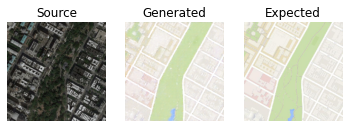

In [27]:
# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load the saved Keras model.
model = load_model('model_003510.h5')
# choose a random image pair from the training dataset to use as an example.
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# provide the source satellite image as input to the model and use it to predict a Google map image
# generate image from source
gen_image = model.predict(src_image)
# plot the source image, generated image, and the expected target image
plot_images(src_image, gen_image, tar_image)
